In [1]:
import numpy as np
import pandas as pd
from hmmlearn import hmm
import matplotlib.pyplot as plt
import torch

import DHMM
from hmmlearn.hmm import MultinomialHMM
from torch.nn import MSELoss

In [2]:
import importlib
importlib.reload(DHMM)

<module 'DHMM' from 'C:\\Users\\jakub\\Documents\\DATA\\Indv_proj\\code\\DHMM.py'>

In [3]:
# Load Test Set

import pickle

dataset_path = "timeseries_all-patients_step-144_len-49769.pkl"
[X_train, X_test, y_train, y_test] = pickle.load(open(dataset_path, 'rb'))


In [4]:
def Dstate_sorting(Model):
    last_col= Model.emissionprob_[:,-1] # Choose the last column
    last_col=last_col.ravel().tolist()
    last_col_sorted=last_col[:]   # Another copy of the list to compare the sorted and normal list
    last_col_sorted.sort(reverse=True)   #since the higher probability the better(Remember the last column corresponds to the best observations.)
    result = [last_col.index(ii) for ii in last_col_sorted]
    return result

def Viterbi_list(Model, Test_data, Feat):   # Test_data is list of numpy arrays.
    traj=[]

    mapping=Dstate_sorting(Model)   # what this one does is the order of elements in descending order

    Temp=mapping[:]
    for ii in range(Test_data.shape[0]):
        count10=1000
        seq1=Test_data[ii,:].reshape((-1,Feat))
        States_Viterbi=Model.predict(seq1)
        L=len(mapping)   # This is number of states
        # we want the highest mastery level is mapped to the highest number.
        for kk in range(L):
            for jj in range(len(States_Viterbi)):
                if (States_Viterbi[jj]==mapping[0]):
                    States_Viterbi[jj]=count10

            del mapping[0]
            count10=count10-1
        mapping=Temp[:]

        traj.append(States_Viterbi)
    count10=1000
    for mm in range(len(traj)):
        ML_old=list(range(count10,count10-L,-1))
        for zz in range(L):
            for vv in range(len(traj[mm])):
                if(traj[mm][vv]==ML_old[0]):
                    traj[mm][vv]=ML_old[0]-(count10-L)
            del ML_old[0]
    return traj


In [6]:
Max_state=3
N_symb=3
Iter=1000

Train_ratio=0.8
Feat=1
N=len(X_train)
T=132
flag=0


X_train = X_train.reshape((X_train.shape[0], X_train.shape[1]))
Data_train = X_train.astype(int)

Model = MultinomialHMM(n_components=Max_state, tol=pow(10,-5))

# Len=[T for ii in range(0,Data_train.shape[0])]   # Lengths must be list
# Model = Model.fit(X_train, Len)

Model = Model.fit(Data_train) #Train


In [5]:
import pickle
Model = pickle.load(open('hmm_state100_10000.pkl', 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: 'hmm_state100_10000.pkl'

In [13]:
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1]))
Test_data = y_test.astype(int)


import math

preds = Viterbi_list(Model, Test_data, 1)
loss_func = MSELoss()
total_loss = 0
esod = 0

for i in range(0, len(Test_data)):
    pred = preds[i]*(400 / Max_state)
    y = Test_data[i]

    #mse
    pred_t = torch.Tensor(pred)
    y_t = torch.Tensor(y)
    loss = loss_func(pred_t, y_t).item()
    total_loss += loss

    #esod
    esod_pred = 0
    esod_y = 0
    for j in range(2, len(pred)):
        esod_pred += math.pow((pred[j] - 2*pred[j-1] + pred[j-2]), 2)
        esod_y += math.pow((y[j] - 2*y[j-1] + y[j-2]), 2)
    if (esod_y != 0):
        esod += esod_pred / esod_y

print("avg loss = ", total_loss/len(Test_data))
print("avg ESOD:", esod/len(Test_data))


# for Test in Test_data:
#     # pred = Model.predict([Test])
#
#     # print(pred)
#
#     # plt.plot(range(0,12), Test )
#     # plt.plot(range(0,12), pred*(400 / Max_state) )
#     # plt.plot(range(0,12), pred2[0]*(400 / Max_state) )
#
#     break


avg loss =  19987.830994951884
avg ESOD: 7397.382289362593


In [7]:
#save
import pickle
pickle.dump(Model, open('hmm_state3_1000.pkl', 'wb'))

## DEMO

In [103]:
print(X_train.shape)
print(X_test.shape)

(39815, 132, 1)
(9954, 132, 1)


In [119]:
Train_ratio=0.8
Max_state=3
Iter=2000
Feat=1
N=len(X_train)
T=132
flag=0
N_symb=3

# Path= 'Exam_4_25_2020.csv'
# Data=pd.read_csv(Path)
# Data=Data.astype(int)
# Data_train = (Data.iloc[0:int(N*Train_ratio),:])
# Test_data=(np.array(Data.iloc[int(N*Train_ratio):N,:]))

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1]))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1]))
Data_train = X_train.astype(int)
Test_data = y_test.astype(int)

First_DHMM = DHMM.Supervised_DHMM(Train_ratio,Max_state,Iter,Feat,N,T,N_symb)

out, score = First_DHMM.Best_States(Data_train, Test_data)


print(score)

The Number of States is 3
-29841629.63351068


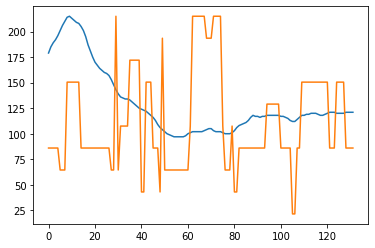

In [117]:
i = 10
plt.plot(range(0,T), Test_data[i] )
plt.plot(range(0,T), out[i]*(max(Test_data[i]) / Max_state) )



In [14]:
url="https://raw.githubusercontent.com/manitadayon/Auto_HMM/main/Exam_4_25_2020.csv"
save_name="Exam_4_25_2020"

import urllib
path_folder = "C:/Users/jakub/Documents/DATA/Indv_proj/code/"
save_name = save_name.replace(' ', '_')
print(save_name)
with urllib.request.urlopen(url) as f:
    text = f.read()
    with open(path_folder+save_name+".csv", 'wb') as f2:
        f2.write(text)
        f2.close()

Exam_4_25_2020
